# Synthetic dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
import shap

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 16

def plot_contribution(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i),fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
        else:
            c = ax.imshow(b[i].reshape(size, size), cmap=plt.get_cmap('viridis', 36), vmin=vmin, vmax=vmax, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='x', colors=(0,0,0,0))
            ax.tick_params(axis='y', colors=(0,0,0,0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.png', bbox_inches='tight')

## Data generation

In [3]:
size = 50

b0 = np.ones((size, size))
b1 = np.ones((size, size))
b2 = np.ones((size, size))
b3 = np.ones((size, size))
b4 = np.ones((size, size))
noise = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b0[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 15**2))
        b1[i, j] = i / 49 * 6
        b2[i, j] = (i + j) / 49 * 3
        b3[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 12**2))
        # b3[i, j] = (j / 49) * 6
        # b3[i, j] = 6 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 6 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))
        noise[i, j] = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

# b3 = np.flip(b2, axis=1).T
# b3 = np.ones(size*size).reshape(-1)*2


In [4]:
# b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = b3.reshape(-1)
# b4 = b4.reshape(-1)
noise = noise.reshape(-1)

In [5]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)
X5 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4, X5]).T
u = np.array([np.linspace(0,size - 1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size - 1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1]
n = X.shape[0]

In [6]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1), columns=['X1', 'X2', 'X3', 'X4', 'X5', 'x_coord', 'y_coord'])

In [7]:
X_coords

X1        X2        X3        X4        X5  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011  1.623438      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414  1.663881      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029 -0.209243      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231  0.540090      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233 -0.125796      4.0      0.0
...        ...       ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451 -1.925222     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732  0.100871     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266  0.610802     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300  1.650016     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717  1.276653     49.0     49.0

[2500 rows x 7 columns]

In [8]:
# f0 = b0
f1 = b1 * X_coords.values[:, 0]
f2 = b2 * X_coords.values[:, 1]
f3 = b3 * X_coords.values[:, 2]
f4 = X_coords.values[:, 3] * 2
f5 = np.abs(X_coords.values[:, 4]) * 2

In [9]:
y = pd.DataFrame(f1 + f2 + f3 + f4 + f5 + noise, columns=['y'])

In [10]:
b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5], noise]

In [11]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$', 'noise']

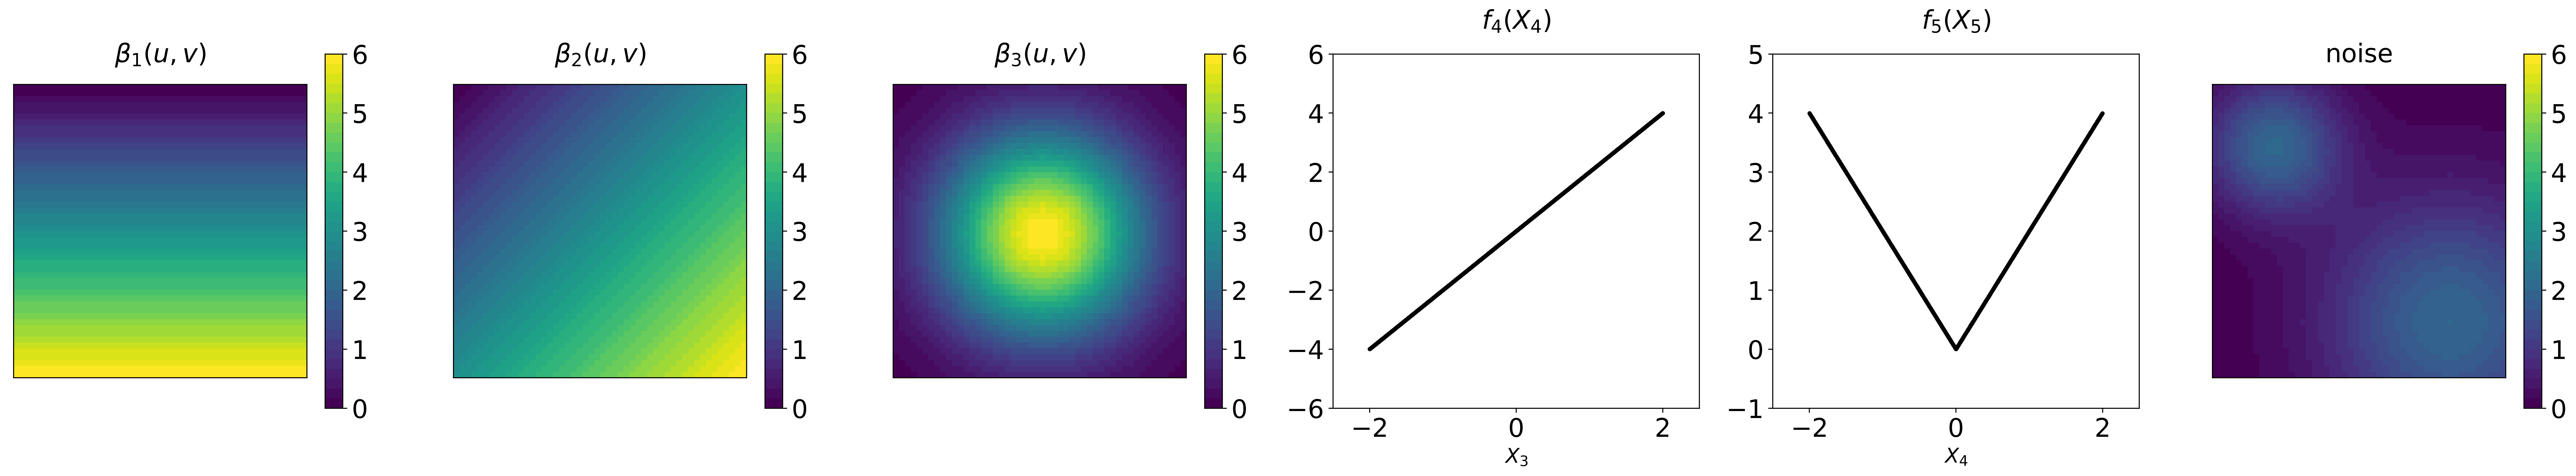

In [12]:
plot_contribution(b=b, k=6, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation', non_spatial=[3, 4])

In [13]:
class Model:
    def __init__(self, f):
        self.predict = f

In [14]:
def predict_with_uncertainty(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 2]
        f4 = X_coords[i, 3] * 2
        f5 = np.abs(X_coords[i, 4]) * 2
        noise = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

        # y = f0 + f1 + f2 + f3 + f4
        y = f1 + f2 + f3 + f4 + f5 + noise
        y_pred.append(y)
    return np.array(y_pred)

In [15]:
def predict_without_uncertainty(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 2]
        f4 = X_coords[i, 3] * 2
        f5 = np.abs(X_coords[i, 4]) * 2

        # y = f0 + f1 + f2 + f3 + f4
        y = f1 + f2 + f3 + f4 + f5
        y_pred.append(y)
    return np.array(y_pred)

In [16]:
true_model_with_uncertainty = Model(predict_with_uncertainty)
true_model_without_uncertainty = Model(predict_without_uncertainty)

In [17]:
loc = X_coords[['x_coord', 'y_coord']]

In [18]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [19]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5, random_state=42)

In [20]:
X_train, X_calib, loc_train, loc_calib = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [21]:
explainer_with_uncertainty = GeoConformalizedExplainer(true_model_with_uncertainty, X_train, X_calib, loc_calib.values, loc.values, 0.1, 10)

In [22]:
results = explainer_with_uncertainty.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

ExactExplainer explainer: 2001it [04:13,  7.69it/s]                          
ExactExplainer explainer: 501it [01:02,  6.66it/s]                         
ExactExplainer explainer: 2501it [05:15,  7.67it/s]                          
100%|██████████| 7/7 [00:00<00:00, 538.44it/s]


In [23]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.8600  0.988994  0.397438  14.351405      13.681755
X2                     1.0000  0.991753  0.336682  13.744534      13.315619
X3                     0.9836  0.993394  0.198416   5.959140       6.224476
X4                     1.0000  0.999483  0.053342   5.507205       5.506029
X5                     0.9992  0.973908  0.185560   1.319676       1.319473
x_coord                0.9872  0.906952  0.255817   0.703313       0.676826
y_coord                0.9768  0.938854  0.336277   1.849365       1.736690

In [24]:
pred_results = results.result

In [25]:
results.result_geo

X1_shap   X2_shap   X3_shap   X4_shap   X5_shap  x_coord_shap  \
0     0.312624  1.470486  0.695236  2.502011  1.012779     -1.272439   
1     1.382264 -0.831999 -0.910299  2.166816  1.093665      0.519451   
2     2.391926 -1.581200 -1.108423 -3.866069 -1.815611      0.873202   
3     1.170389  1.765174 -1.235835 -0.730474 -1.153916     -0.513262   
4    -2.971105 -0.050469 -0.720223  2.242454 -1.982504      0.019993   
...        ...       ...       ...       ...       ...           ...   
2495 -7.649608 -3.503404 -0.114752 -2.608851  1.616411     -0.661259   
2496  1.884622 -3.013441  0.330051  0.815516 -2.032292     -0.759925   
2497 -7.282752 -4.730231 -0.754701  3.134583 -1.012430     -0.646033   
2498 -2.280349 -4.797417  0.546748  4.116652  1.065999     -1.178392   
2499  4.514619 -3.459872  0.364926  1.093486  0.319273     -0.945411   

      y_coord_shap  X1_value  X2_value  X3_value  ...  x_coord_pred  \
0        -1.264360  0.104114  0.964917  1.011381  ...     -1.270863   
1        -0.410732  0.741269 -0.440030 -0.936705  ...      0.542786   
2        -0.945638  1.342697 -0.875739 -1.148677  ...      0.939989   
3        -1.286809  0.615061  1.082512 -1.266801  ...     -0.392616   
4         3.493095 -1.851912  0.026923 -0.659943  ...      0.069454   
...            ...       ...       ...       ...  ...           ...   
2495     -3.480136 -1.798074 -0.779403  0.012337  ...     -0.449092   
2496     -0.929738  0.239688 -0.666447  0.497581  ...     -0.525983   
2497     -3.248771 -1.719665 -1.038000 -0.700350  ...     -0.256404   
2498     -2.442551 -0.650496 -1.045958  0.776005  ...     -0.401711   
2499     -0.239715  0.801800 -0.750421  0.581807  ...     -0.744488   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.524498             0.720351            -0.885464   
1                    0.545211             0.720351            -0.045068   
2                    0.545211             0.720351            -0.520967   
3                    0.545211             0.720351            -0.773974   
4                    0.545211             0.720351             3.749904   
...                       ...                  ...                  ...   
2495                 0.876927             0.720351            -2.264147   
2496                 0.841217             0.720351             0.425064   
2497                 0.811421             0.720351            -1.756630   
2498                 0.811421             0.720351            -0.954648   
2499                 0.811421             0.720351             1.082287   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -1.934459                        0.9768     -1.409962   0.0   
1               -1.135490                        0.9768     -0.590279   1.0   
2               -1.611389                        0.9768     -1.066178   2.0   
3               -1.864396                        0.9768     -1.319185   3.0   
4                2.659483                        0.9768      3.204693   4.0   
...                   ...                           ...           ...   ...   
2495            -4.018001                        0.9768     -3.141074  45.0   
2496            -1.257370                        0.9768     -0.416153  46.0   
2497            -3.379471                        0.9768     -2.568050  47.0   
2498            -2.577489                        0.9768     -1.766068  48.0   
2499            -0.540554                        0.9768      0.270867  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [26]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred', 'X5_pred']]

In [27]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, b['X3_pred'].values, [X_coords.values[:, 3], b['X4_pred'].values, -6, 6], [X_coords.values[:, 4], b['X5_pred'].values, -3, 3]]

In [28]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_{4}(X_4)$', r'$f_5(X_5)$']

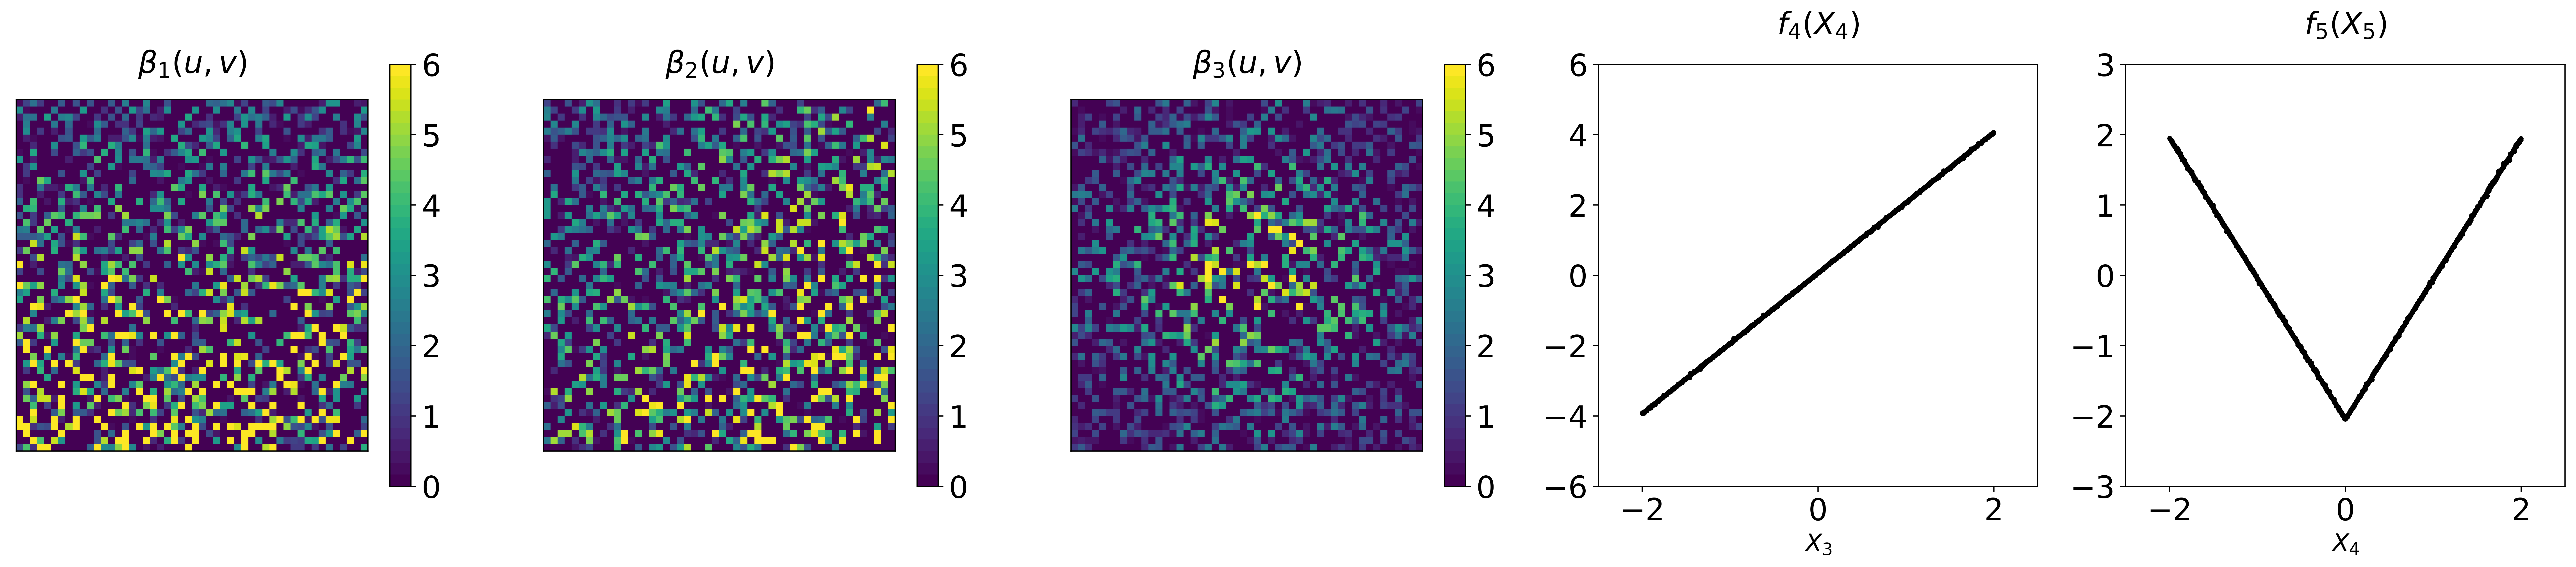

In [29]:
plot_contribution(pred_b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4])

In [30]:
X1_cover = (pred_results['X1_pred'] <= pred_results['X1_upper_bound']) & (pred_results['X1_pred'] >= pred_results['X1_lower_bound'])

In [31]:
X2_cover = (pred_results['X2_pred'] <= pred_results['X2_upper_bound']) & (pred_results['X2_pred'] >= pred_results['X2_lower_bound'])

In [32]:
X3_cover = (pred_results['X3_pred'] <= pred_results['X3_upper_bound']) & (pred_results['X3_pred'] >= pred_results['X3_lower_bound'])

In [33]:
b_cover = [X1_cover.values, X2_cover.values, X3_cover.values]

In [34]:
sub_titles = [r'$Cover_1$', r'$Cover_2$', r'$Cover_3$']

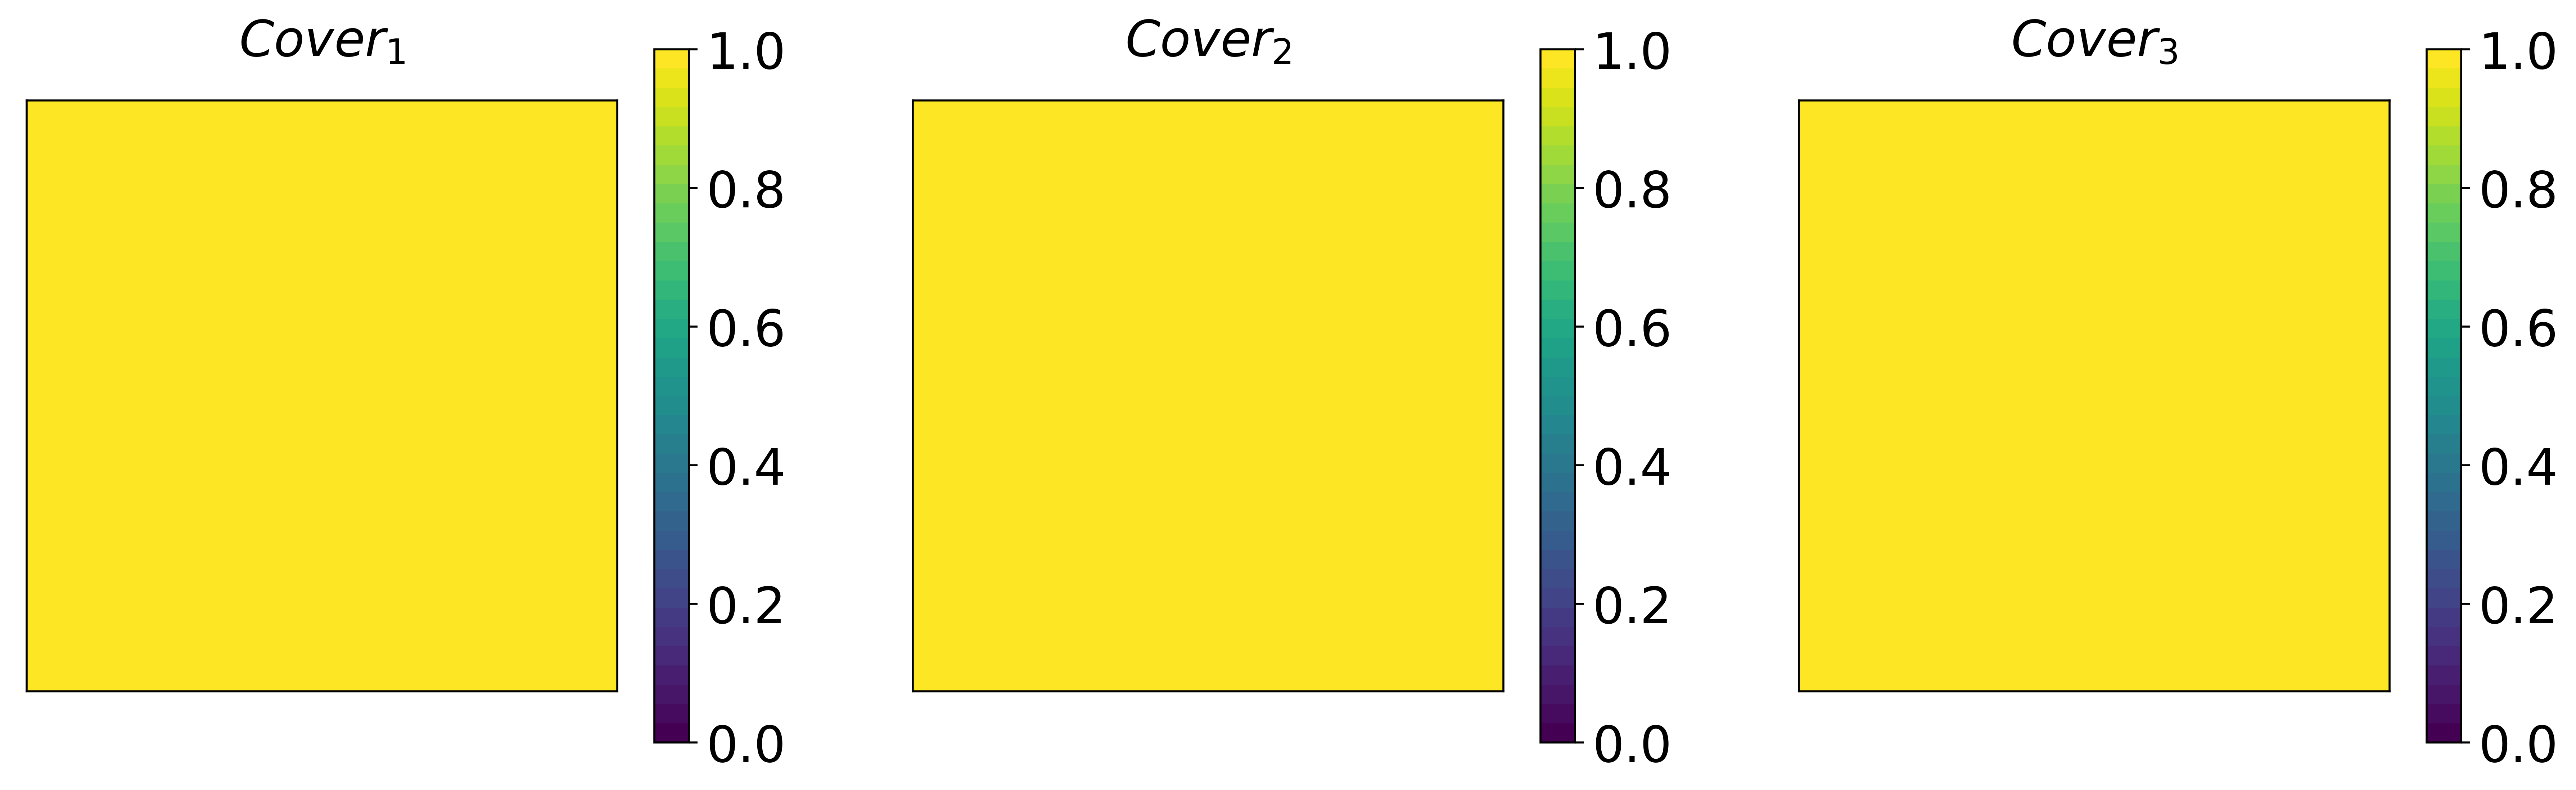

In [35]:
plot_contribution(b_cover, k=3, sub_titles=sub_titles, vmin=0, vmax=1, title='Coverage - ConformalSHAP', non_spatial=[])

In [36]:
plt.rcParams['font.size'] = 16

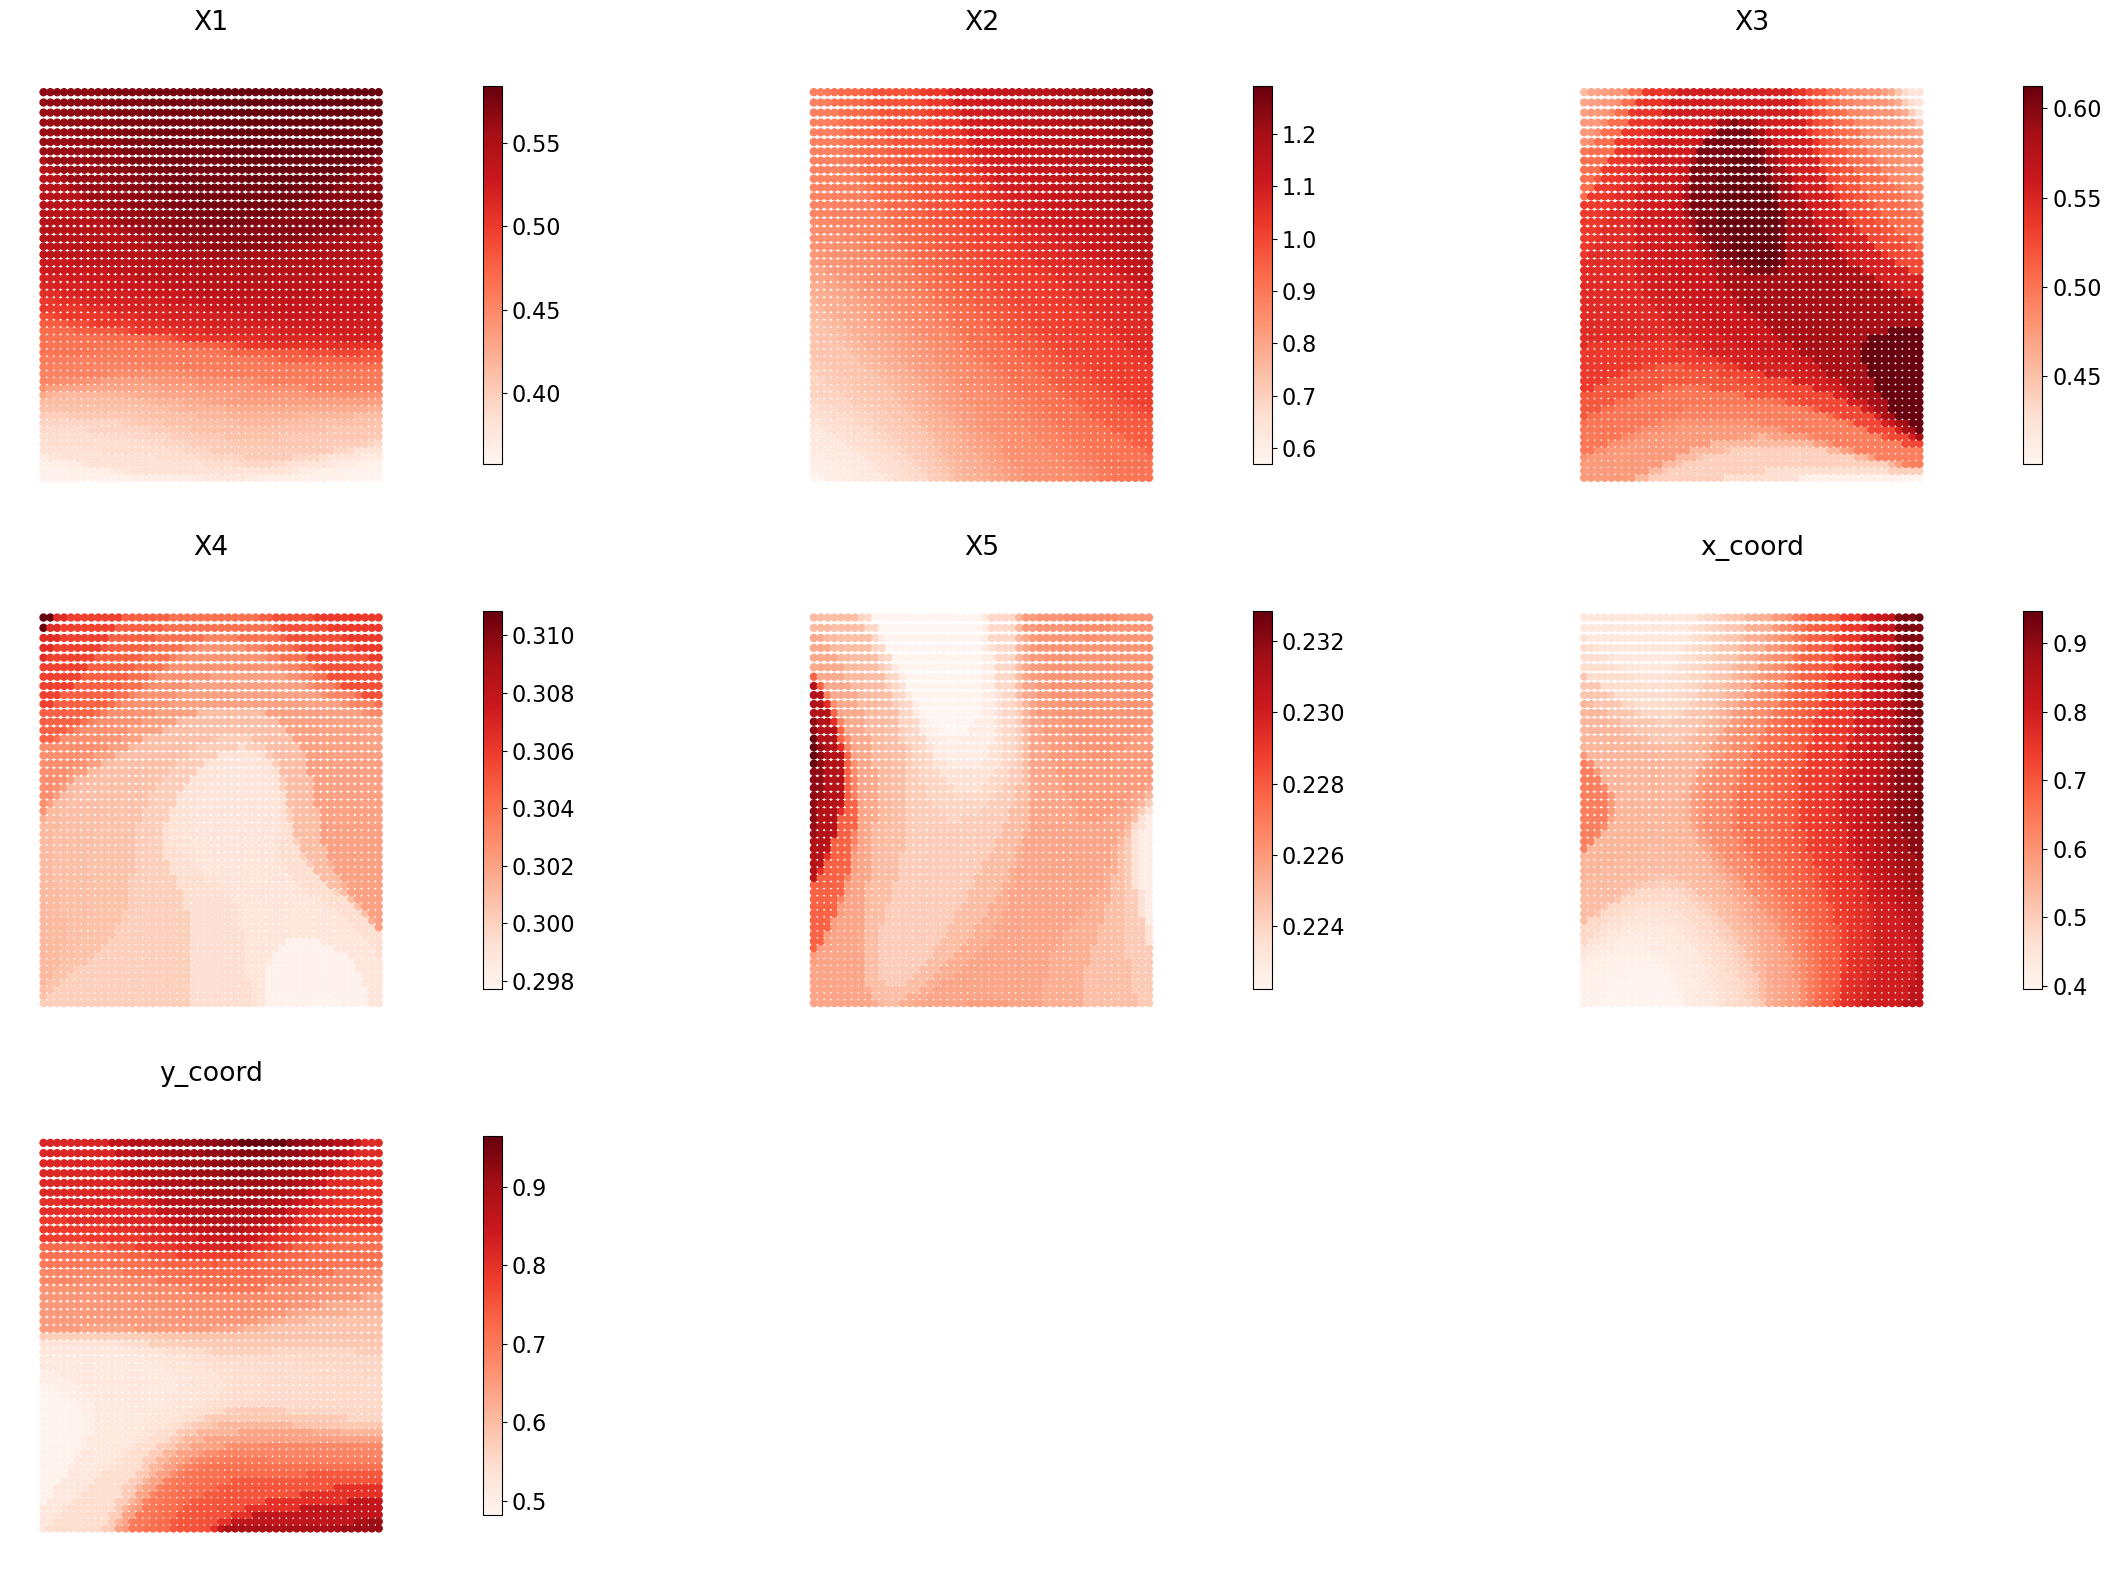

In [37]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [38]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [39]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

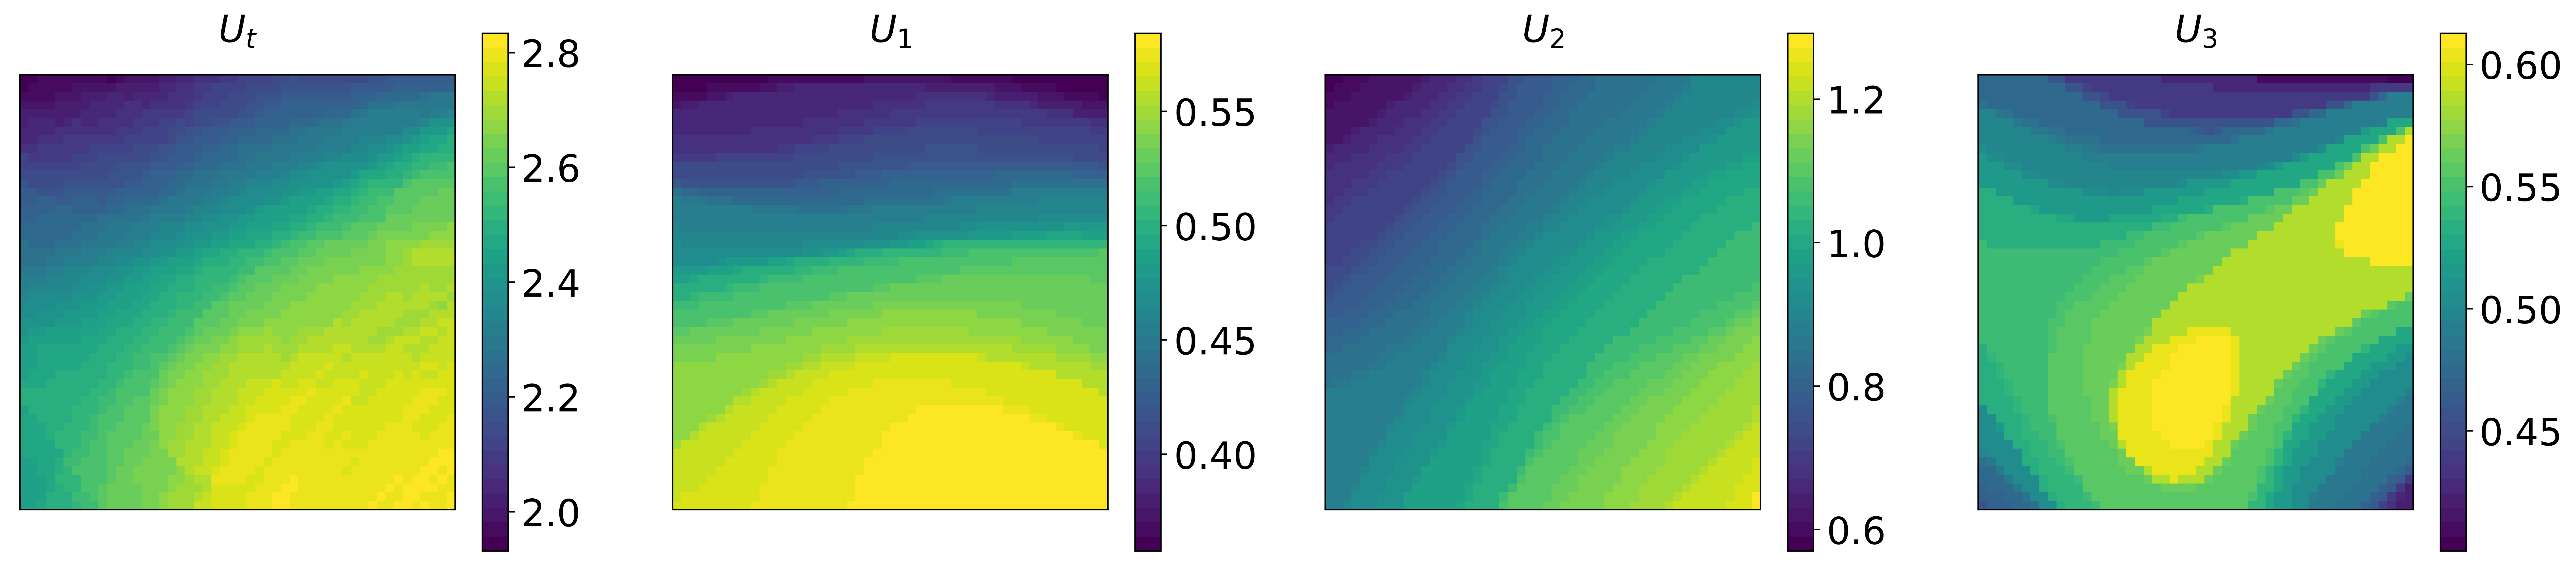

In [40]:
plot_contribution([geo_uncertainty_sum.values, pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=4, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

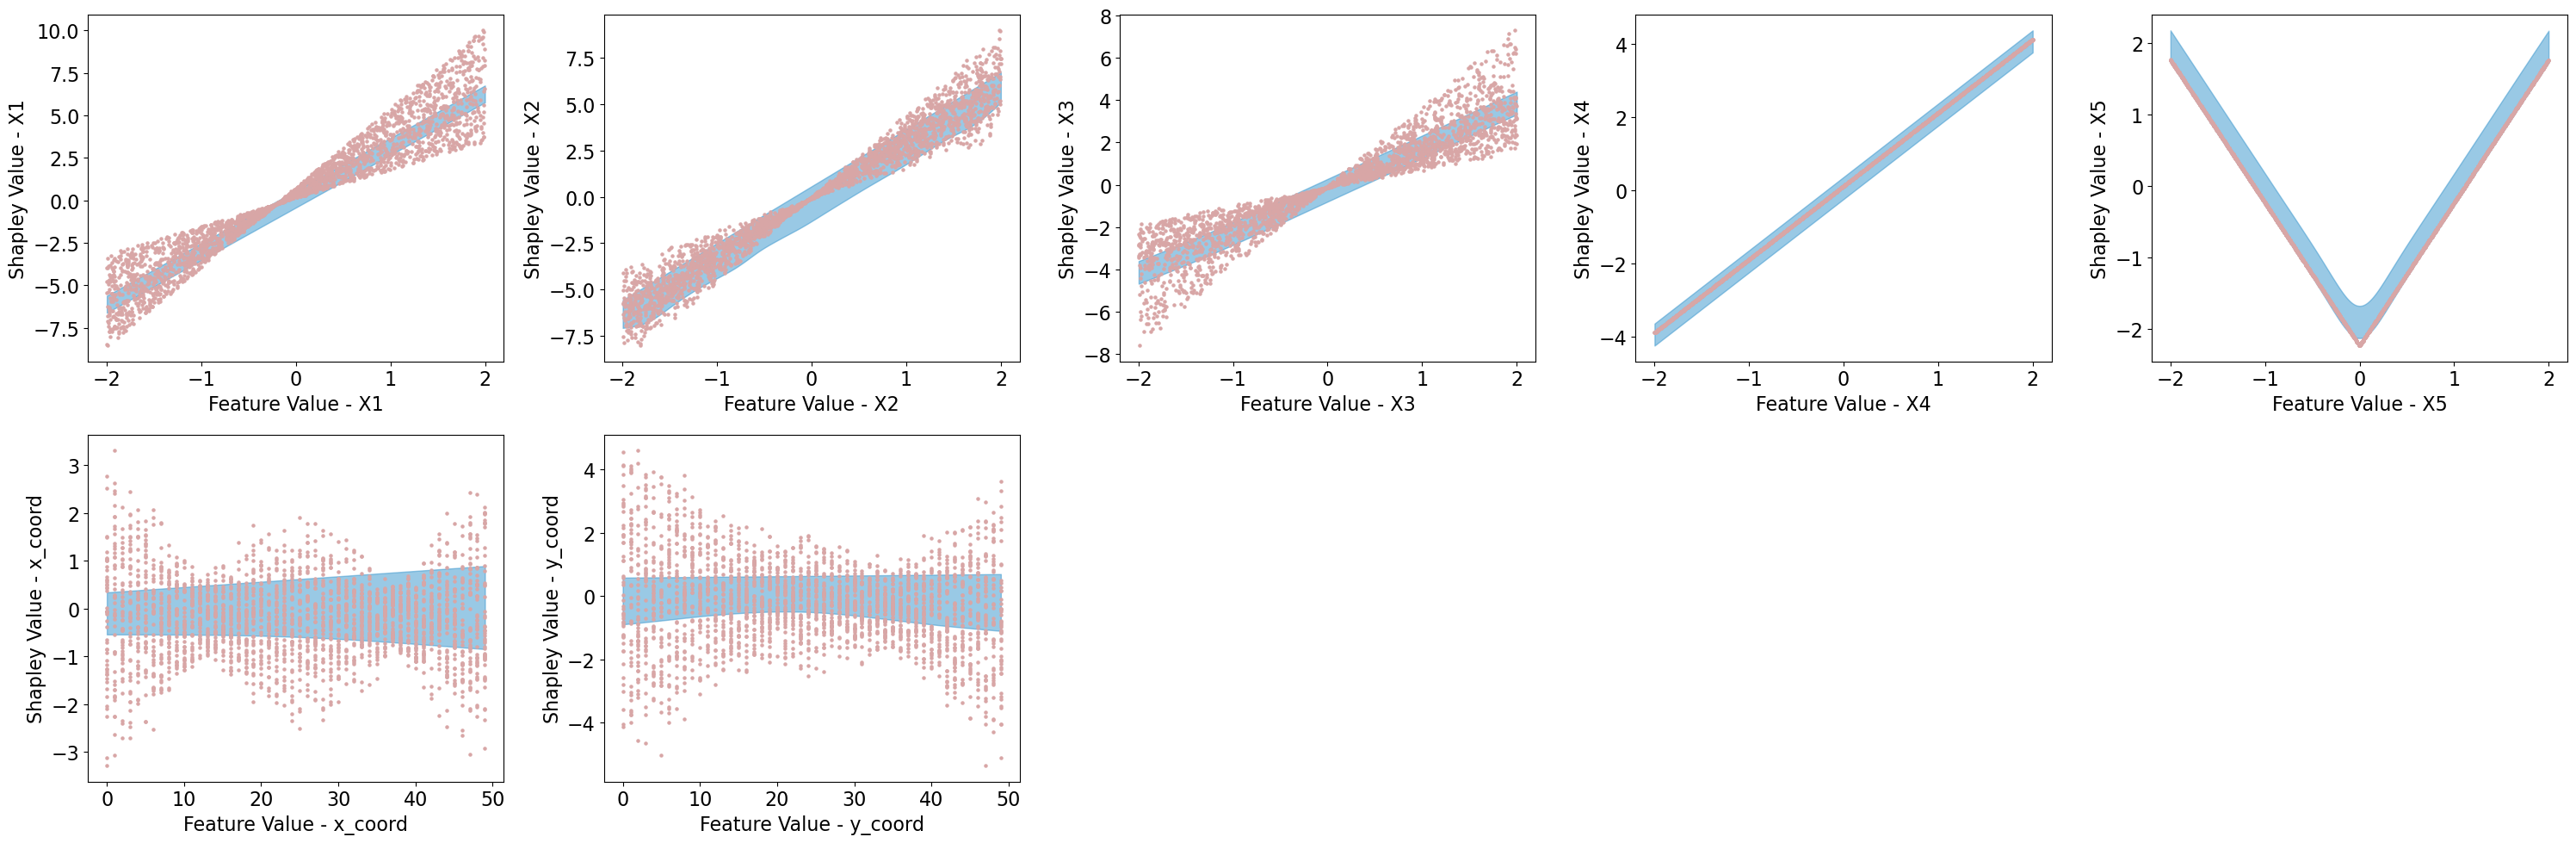

In [41]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)

In [42]:
explainer_without_uncertainty = GeoConformalizedExplainer(true_model_without_uncertainty, X_train, X_calib, loc_calib.values, loc.values, 0.1, 10)

In [43]:
results = explainer_without_uncertainty.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

ExactExplainer explainer: 2001it [02:22, 13.56it/s]                          
ExactExplainer explainer: 501it [00:34, 10.17it/s]                         
ExactExplainer explainer: 2501it [02:51, 13.69it/s]                          
100%|██████████| 7/7 [00:00<00:00, 3521.67it/s]


In [44]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.8728  0.988969  0.397881  14.351401      13.683207
X2                     1.0000  0.991715  0.337455  13.744562      13.308944
X3                     0.9860  0.993318  0.199544   5.959096       6.226411
X4                     1.0000  0.999486  0.053227   5.507205       5.506029
X5                     0.9988  0.973932  0.185472   1.319614       1.319419
x_coord                0.9836  0.906979  0.255777   0.703302       0.679455
y_coord                0.9804  0.937806  0.339158   1.849501       1.726280

In [45]:
pred_results = results.result

In [46]:
results.result_geo

X1_shap   X2_shap   X3_shap   X4_shap   X5_shap  x_coord_shap  \
0     0.402282  1.560145  0.784895  2.591669  1.102437     -1.182780   
1     1.471923 -0.742340 -0.820640  2.256475  1.183324      0.609109   
2     2.481585 -1.491541 -1.018764 -3.776410 -1.725953      0.962861   
3     1.260048  1.854833 -1.146176 -0.640815 -1.064257     -0.423604   
4    -2.881446  0.039190 -0.630565  2.332113 -1.892845      0.109652   
...        ...       ...       ...       ...       ...           ...   
2495 -7.560012 -3.413808 -0.025156 -2.519255  1.706007     -0.571663   
2496  1.974218 -2.923845  0.419647  0.905112 -1.942696     -0.670329   
2497 -7.193156 -4.640635 -0.665105  3.224179 -0.922834     -0.556437   
2498 -2.190753 -4.707821  0.636344  4.206248  1.155595     -1.088796   
2499  4.604215 -3.370276  0.454522  1.183082  0.408869     -0.855815   

      y_coord_shap  X1_value  X2_value  X3_value  ...  x_coord_pred  \
0        -1.176394  0.104114  0.964917  1.011381  ...     -1.161503   
1        -0.322766  0.741269 -0.440030 -0.936705  ...      0.654996   
2        -0.857672  1.342697 -0.875739 -1.148677  ...      1.013854   
3        -1.198843  0.615061  1.082512 -1.266801  ...     -0.325291   
4         3.581061 -1.851912  0.026923 -0.659943  ...      0.173907   
...            ...       ...       ...       ...  ...           ...   
2495     -3.391793 -1.798074 -0.779403  0.012337  ...     -0.343249   
2496     -0.841395  0.239688 -0.666447  0.497581  ...     -0.501856   
2497     -3.160428 -1.719665 -1.038000 -0.700350  ...      0.374578   
2498     -2.354208 -0.650496 -1.045958  0.776005  ...     -0.885909   
2499     -0.151372  0.801800 -0.750421  0.581807  ...     -0.639494   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.634461             0.731734            -0.718301   
1                    0.652817             0.731734             0.155011   
2                    0.656683             0.731734            -0.326054   
3                    0.708346             0.731734            -0.555634   
4                    0.708346             0.731734             3.944274   
...                       ...                  ...                  ...   
2495                 0.850418             0.731734            -2.222259   
2496                 0.850418             0.731734             0.491170   
2497                 0.800116             0.731734            -1.741606   
2498                 0.800116             0.731734            -0.826208   
2499                 0.797657             0.731734             1.161807   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -1.987223                        0.9804     -1.352762   0.0   
1               -1.150624                        0.9804     -0.497807   1.0   
2               -1.639420                        0.9804     -0.982737   2.0   
3               -1.972325                        0.9804     -1.263979   3.0   
4                2.527582                        0.9804      3.235928   4.0   
...                   ...                           ...           ...   ...   
2495            -3.923095                        0.9804     -3.072677  45.0   
2496            -1.209666                        0.9804     -0.359248  46.0   
2497            -3.341838                        0.9804     -2.541722  47.0   
2498            -2.426440                        0.9804     -1.626324  48.0   
2499            -0.433507                        0.9804      0.364150  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [47]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred', 'X5_pred']]

In [48]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, b['X3_pred'].values, [X_coords.values[:, 3], b['X4_pred'].values, -6, 6], [X_coords.values[:, 4], b['X5_pred'].values, -2, 5]]

In [49]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_{4}(X_4)$', r'$f_5(X_5)$']

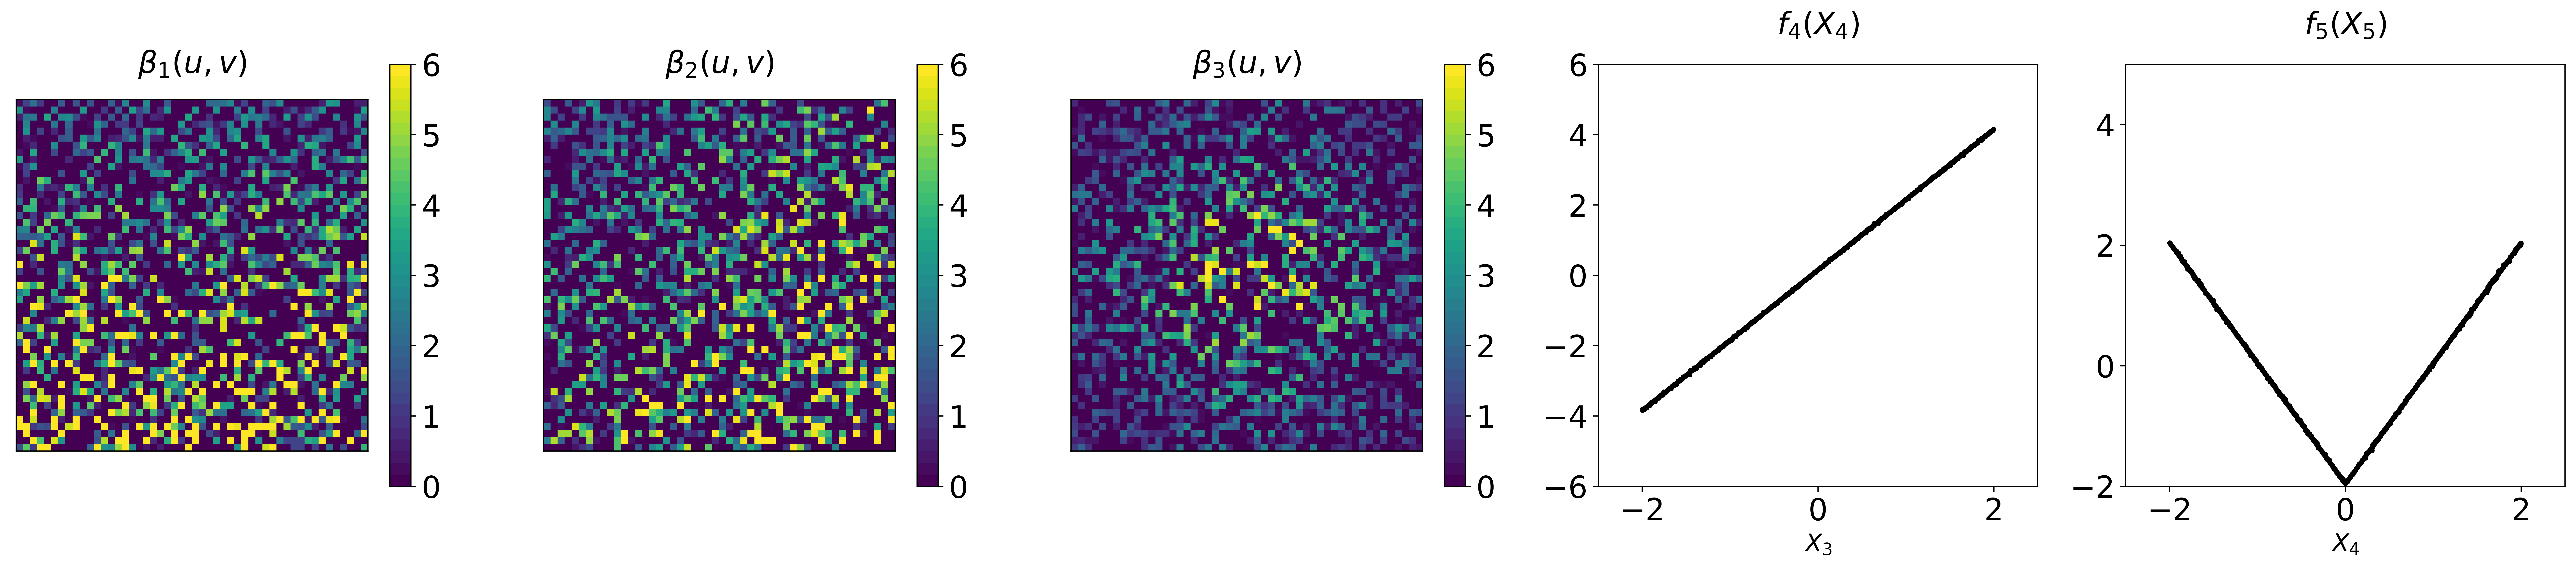

In [50]:
plot_contribution(pred_b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4])

In [51]:
plt.rcParams['font.size'] = 16

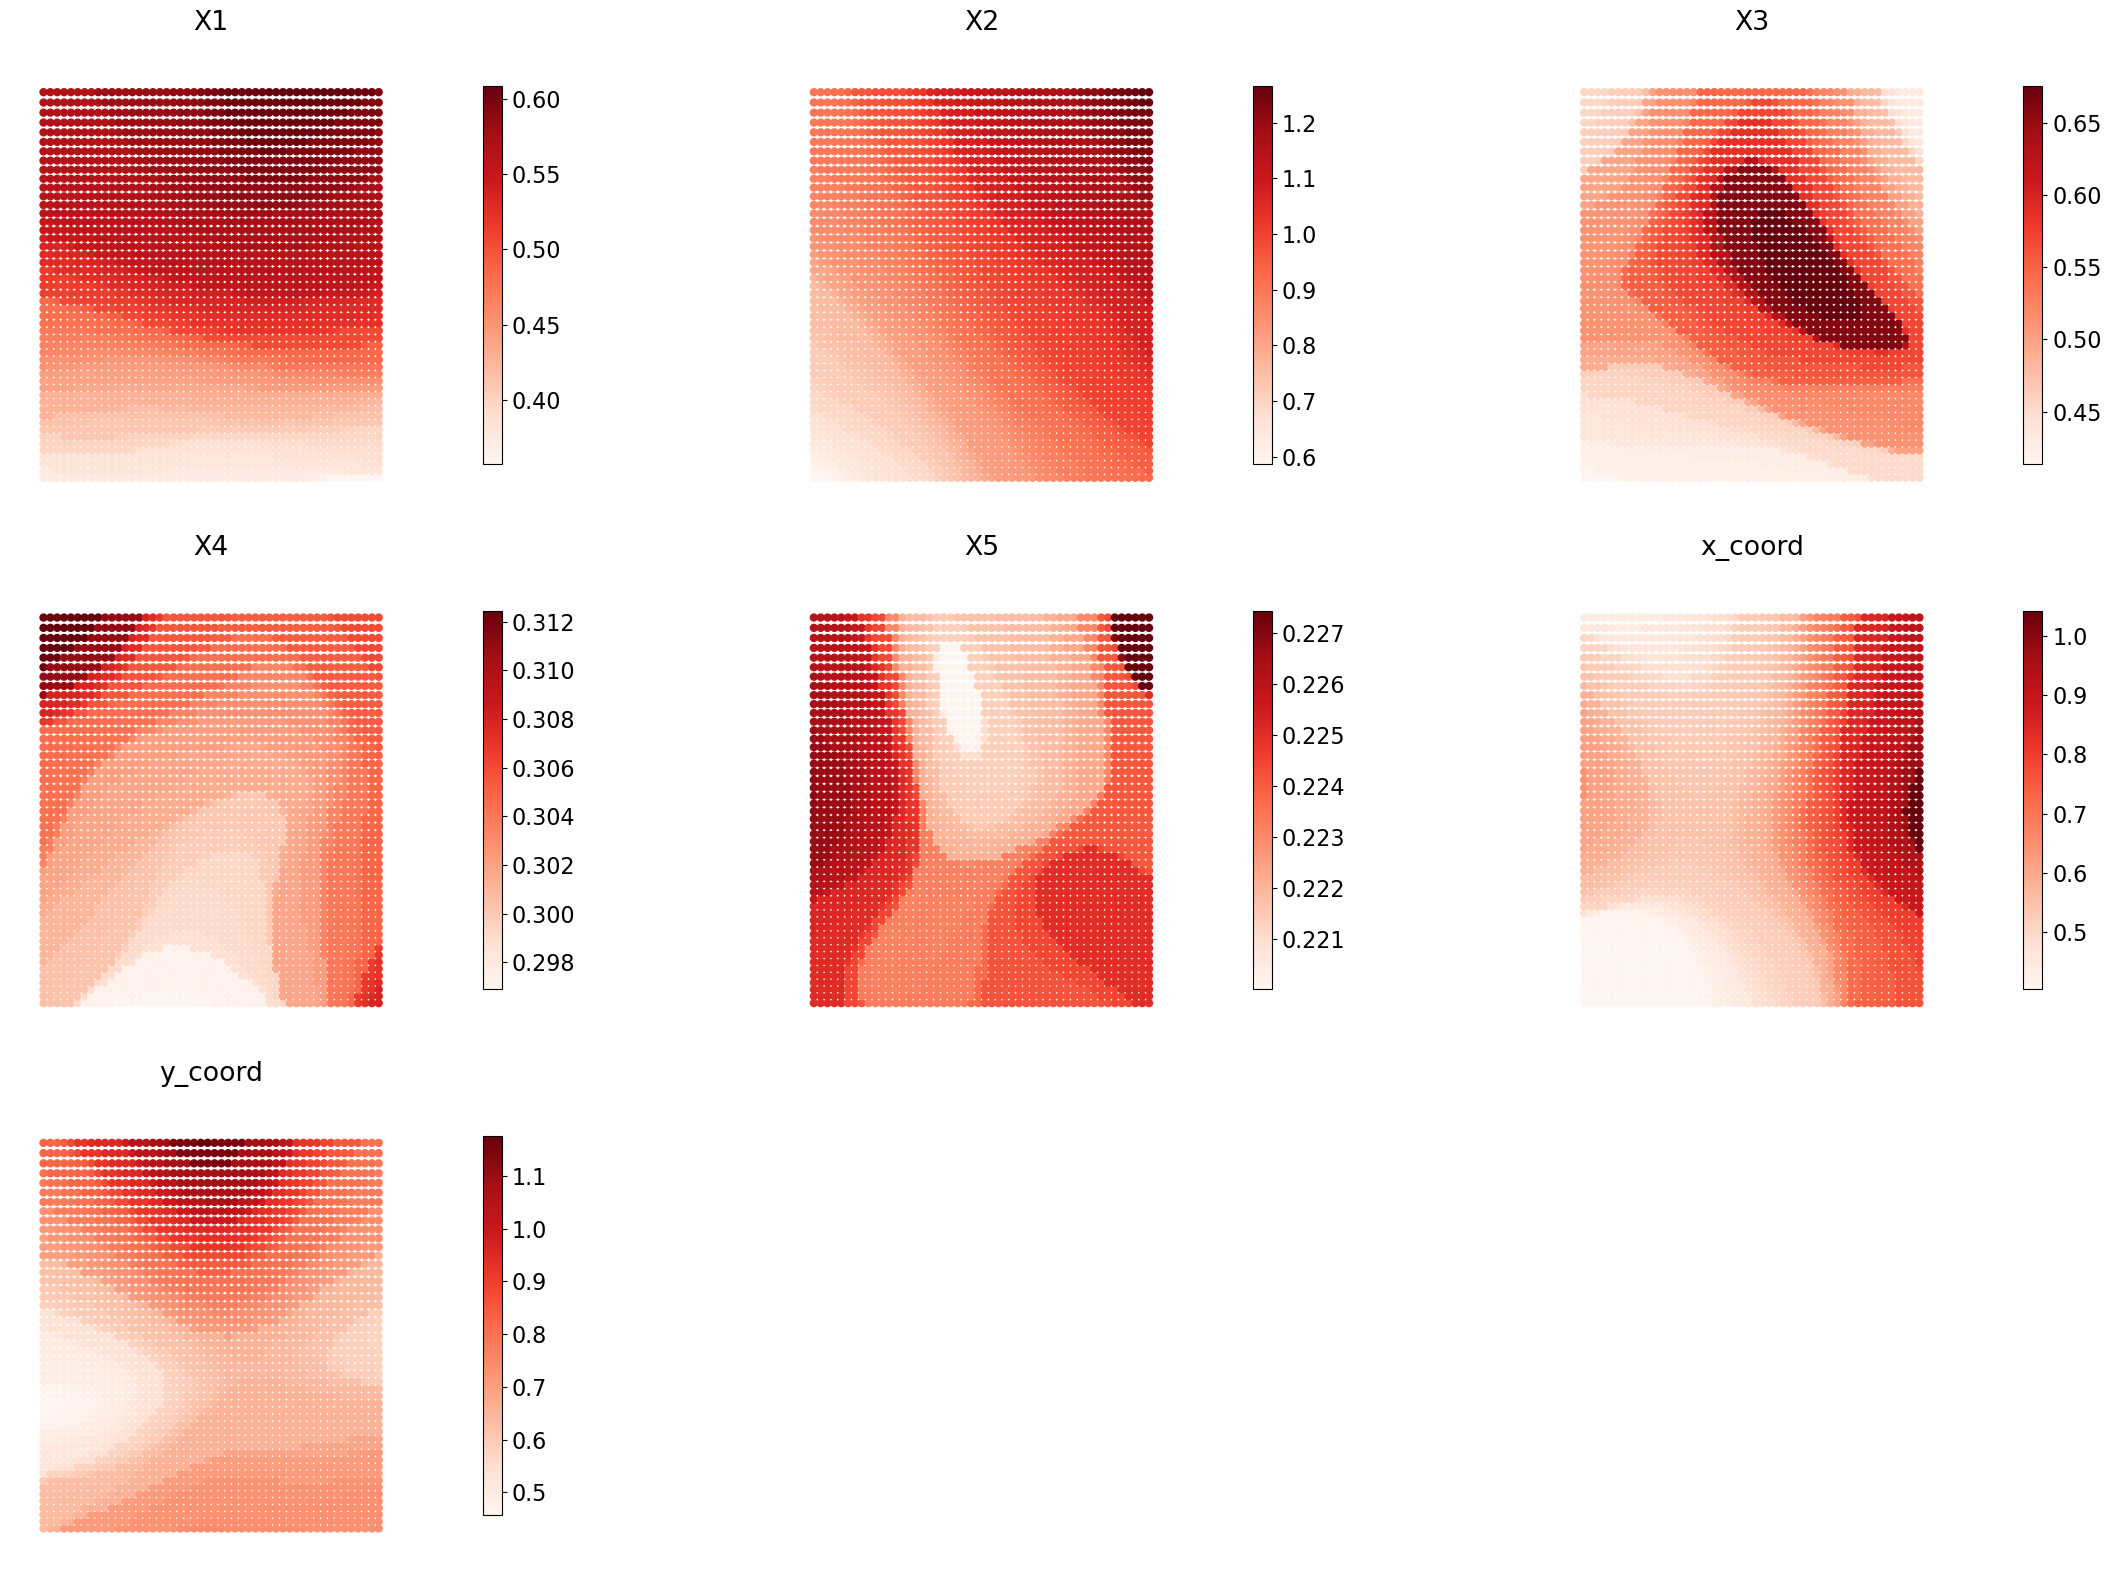

In [52]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [53]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [54]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

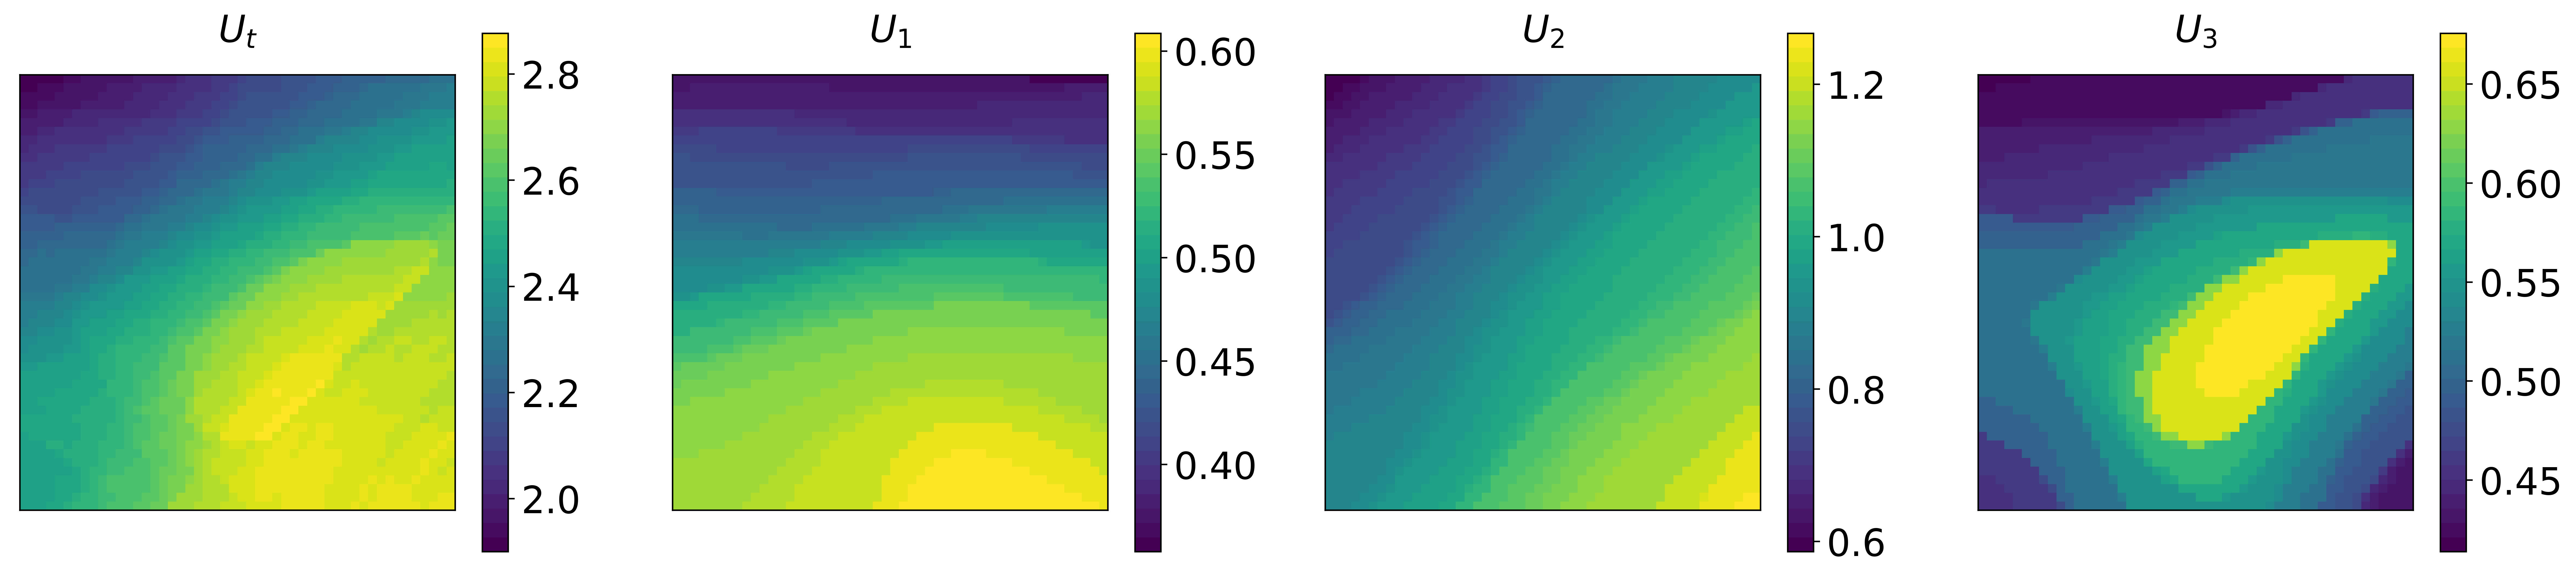

In [55]:
plot_contribution([geo_uncertainty_sum.values, pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=4, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

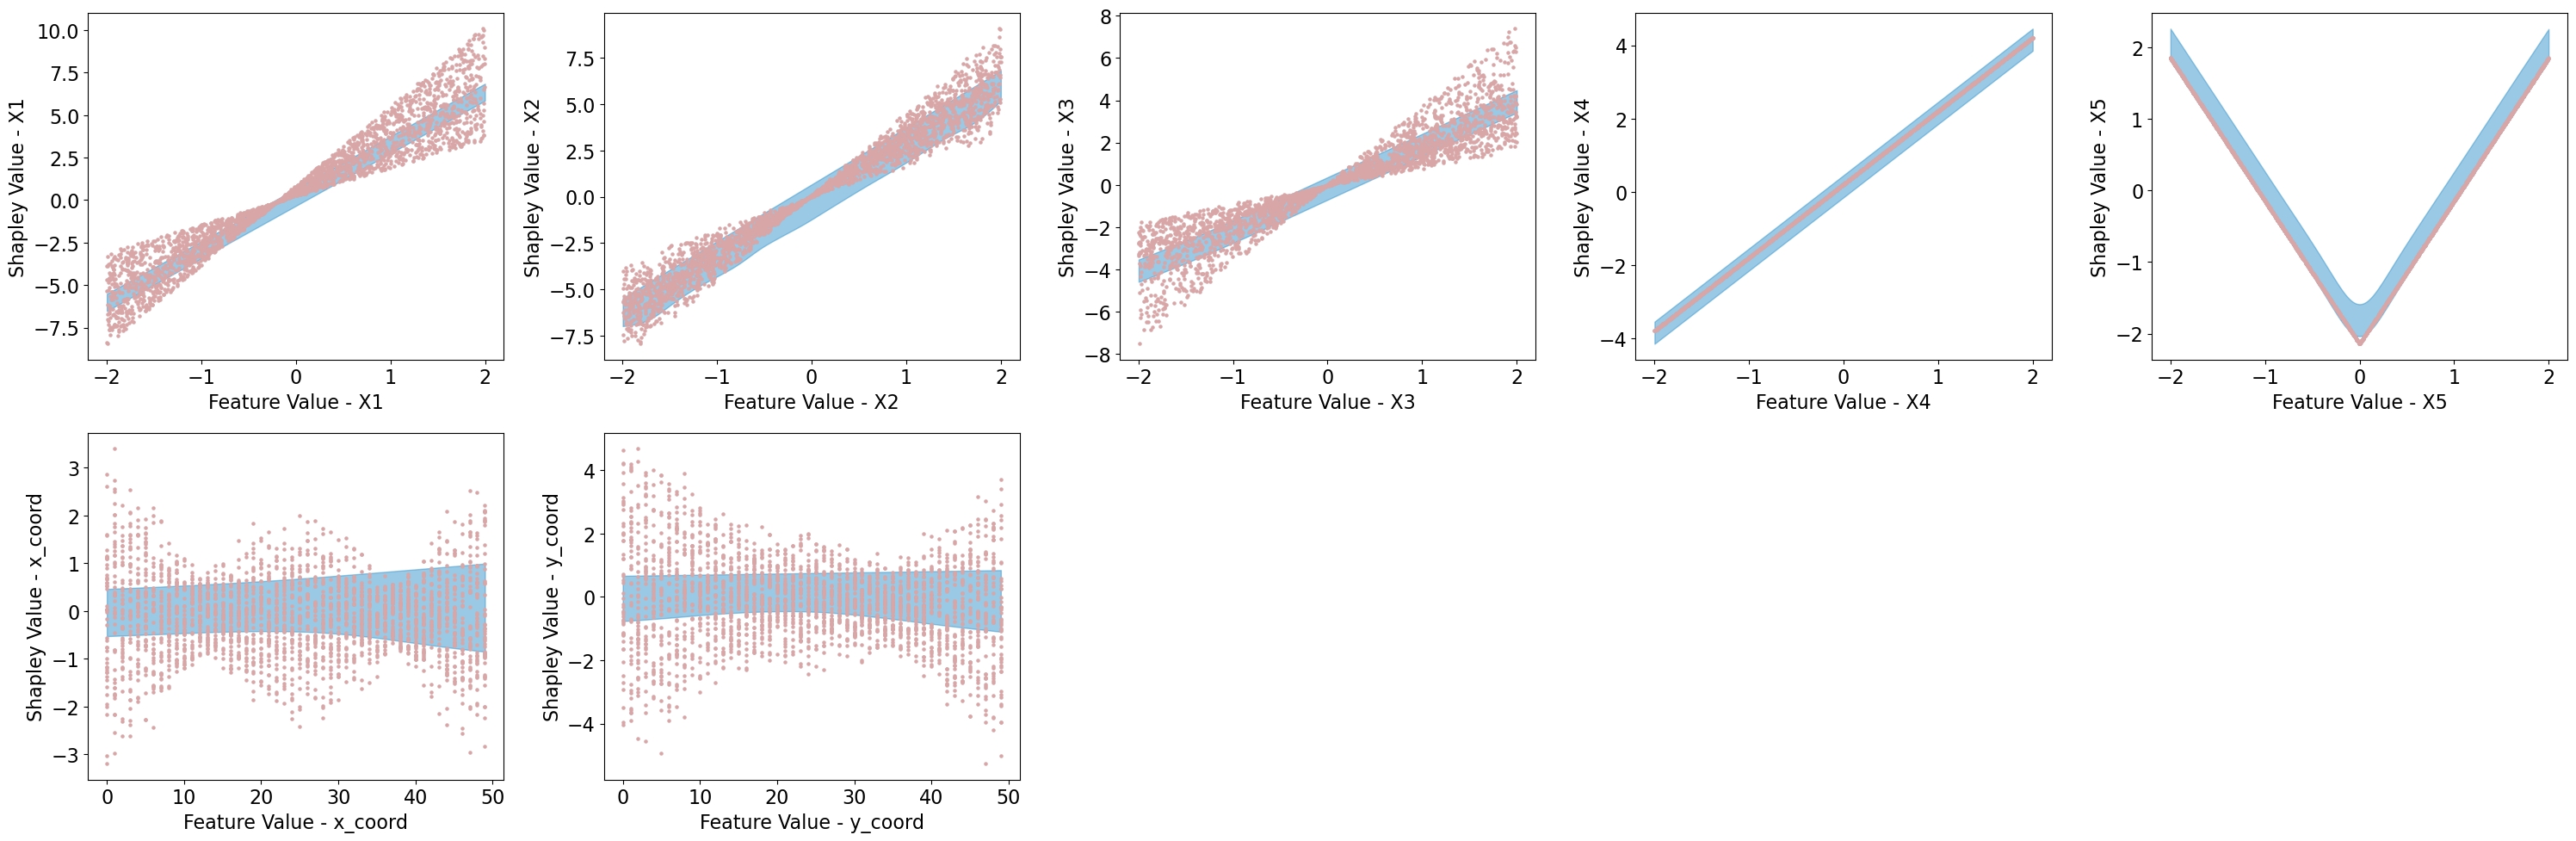

In [56]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)